## Introduction
This notebook delves into deep learning by implementing a 1D Convolutional Neural Network (1D CNN) model, inspired by the MSDeepAMR architecture.  A key aspect of this work is addressing the problem as a multilabel task, which allows the model to capture the correlations between different antibiotic resistance profiles. The notebook evaluates how this advanced model performs compared to the classic baseline, particularly in the presence of imbalanced data, demonstrating its potential to improve predictive accuracy.

### Data Preparation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.preprocessing import Normalizer
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.layers import Activation, Dense, Conv1D, Flatten, MaxPooling1D, Dropout, BatchNormalization

from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
)

import warnings
warnings.filterwarnings('ignore')

Load Dataset

In [ ]:
if os.path.exists('../data/e_coli_driams_a_bin3_2000_20000Da.csv'):
    df = pd.read_csv('../data/e_coli_driams_a_bin3_2000_20000Da.csv')
else:
    df = pd.read_csv('https://media.githubusercontent.com/media/xlopez-ml/DL-AMR/master/datasets/driams_a/s_aureus_driams_a_bin3_2000_20000Da.csv')

In [ ]:
df.head()

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19991,19994,19997,code,species,Oxacillin,Clindamycin,Ceftriaxone,Ciprofloxacin,Fusidic acid
0,951.428571,826.125000,944.857143,898.428571,1007.714286,936.000000,828.571429,812.000000,782.714286,741.625000,...,35.5,20.5,27.342857,029f0abf-1664-424f-88cb-11c9c8af2b11,Staphylococcus aureus,0.0,0.0,0.0,0.0,1.0
1,784.714286,701.125000,681.571429,762.142857,737.571429,733.000000,735.857143,659.571429,802.714286,554.375000,...,30.0,40.5,34.695238,08149af1-10f5-4f02-81d8-3d46d66d4a7a,Staphylococcus aureus,0.0,0.0,0.0,0.0,0.0
2,50.875000,89.142857,56.142857,151.285714,132.714286,110.428571,47.285714,63.428571,100.375000,52.142857,...,2.5,30.5,11.288462,08fe3876-ecee-4ddc-9aa9-a84f605757f7,Staphylococcus aureus,0.0,0.0,0.0,0.0,0.0
3,843.285714,816.500000,734.428571,1027.142857,979.428571,875.571429,912.142857,714.428571,945.428571,886.500000,...,15.5,8.0,20.057143,0a9fdd4b-7180-47c0-849e-cb32d46da94c,Staphylococcus aureus,0.0,0.0,0.0,0.0,0.0
4,307.857143,295.000000,246.714286,181.571429,258.000000,318.714286,295.714286,300.857143,278.142857,256.125000,...,25.5,32.0,24.990476,0d82f4c4-473c-49d8-8c85-e3e36e96d047,Staphylococcus aureus,1.0,0.0,1.0,1.0,0.0


In [ ]:
df = df.rename(columns={'Fusidic acid': 'Fusidic_acid'})

In [ ]:
antibiotics = df.columns[-5:].to_list()
antibiotics

['Oxacillin', 'Clindamycin', 'Ceftriaxone', 'Ciprofloxacin', 'Fusidic_acid']

In [ ]:
def create_dataset(df, antibiotic, max_length):
    antibiotic_df = df.iloc[:, :max_length].join(df[antibiotic])
    antibiotic_df = antibiotic_df.dropna(how='any').reset_index(drop=True)

    X = antibiotic_df.iloc[:, 0:6000].values
    y = antibiotic_df.iloc[:, 6000:].values

    X = np.asarray(X).astype(np.float32)
    y = np.asarray(y).astype(np.float32)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)

    scaler=Normalizer(norm='max')
    sc_X = scaler
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.transform(X_test)

    sample_size = X_train.shape[0]
    time_steps  = X_train.shape[1]
    input_dimension = 1

    X_train_reshaped = X_train.reshape(sample_size,time_steps,input_dimension)
    X_test_reshaped = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

    return X_train_reshaped, X_test_reshaped, y_train, y_test

Set Antibiotic

In [ ]:
antibiotic = antibiotics[0]

X_train, X_test, y_train, y_test = create_dataset(df, antibiotic, 6000)

### Create Model

In [ ]:
def create_model(name, n_features, n_timesteps, n_targets):
    METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ]

    model = Sequential(name=name)
    init_mode = 'normal'
    model.add(Conv1D(filters=(64), kernel_size=(17), input_shape = (n_timesteps,n_features), name='Conv_1'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_1"))

    model.add(Conv1D(filters=(128), kernel_size=(9),kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),  name='Conv_2'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_2"))

    model.add(Conv1D(filters=(256), kernel_size=(5),kernel_initializer=init_mode,kernel_regularizer=regularizers.l2(0.0001),   name='Conv_3'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_3"))

    model.add(Conv1D(filters=(256), kernel_size=(5),kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),   name='Conv_4'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_4"))

    model.add(Flatten())
    model.add(Dropout(0.65))
    model.add(Dense(256, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001), name="fully_connected_0"))
    model.add(Dense(64, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001), name="fully_connected_1"))
    model.add(Dense(64, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),  name="fully_connected_2"))
    model.add(Dense(n_targets, activation='sigmoid', name="OUT_Layer"))

    model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy',  metrics=METRICS)

    return model

In [ ]:
_, n_timesteps, n_features = X_train.shape

model = create_model(f'e_coli_{antibiotic}_model', n_features, n_timesteps, n_targets=1)
model.summary()

Model: "e_coli_Oxacillin_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv_1 (Conv1D)                 │ (None, 5984, 64)       │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 5984, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 5984, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling1D_1 (MaxPooling1D)   │ (None, 2992, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_2 (Conv1D)                 │ (None, 2984, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2984, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 2984, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling1D_2 (MaxPooling1D)   │ (None, 1492, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_3 (Conv1D)                 │ (None, 1488, 256)      │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1488, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 1488, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling1D_3 (MaxPooling1D)   │ (None, 744, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_4 (Conv1D)                 │ (None, 740, 256)       │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 740, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 740, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling1D_4 (MaxPooling1D)   │ (None, 370, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 94720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 94720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fully_connected_0 (Dense)       │ (None, 256)            │    24,248,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fully_connected_1 (Dense)       │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fully_connected_2 (Dense)       │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ OUT_Layer (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,839,105 (94.75 MB)

 Trainable params: 24,837,697 (94.75 MB)

 Non-trainable params: 1,408 (5.50 KB)

### Fit Model

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.000001)
early_st = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=1, validation_split=0.1, callbacks=[reduce_lr,early_st])

Epoch 1/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 34s 83ms/step - accuracy: 0.7803 - auc: 0.5708 - fn: 254.0110 - fp: 41.0328 - loss: 6.5020 - prc: 0.2435 - precision: 0.2671 - recall: 0.0717 - tn: 1066.3175 - tp: 13.5876 - val_accuracy: 0.8158 - val_auc: 0.6329 - val_fn: 56.0000 - val_fp: 0.0000e+00 - val_loss: 5.8850 - val_prc: 0.3024 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 248.0000 - val_tp: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.8139 - auc: 0.6406 - fn: 251.4671 - fp: 14.9343 - loss: 5.6539 - prc: 0.2812 - precision: 0.4079 - recall: 0.0327 - tn: 1098.7153 - tp: 9.8321 - val_accuracy: 0.8158 - val_auc: 0.8277 - val_fn: 56.0000 - val_fp: 0.0000e+00 - val_loss: 5.2349 - val_prc: 0.5528 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 248.0000 - val_tp: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.8093 - auc: 0.7077 - fn: 223.0

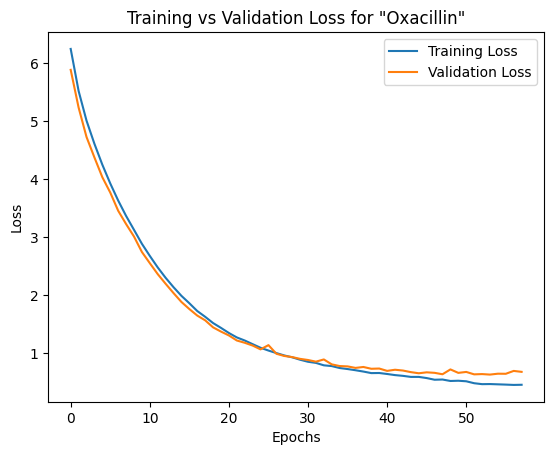

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training vs Validation Loss for "{antibiotic}"')
plt.legend()
plt.show()


### Model Evaluation

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step


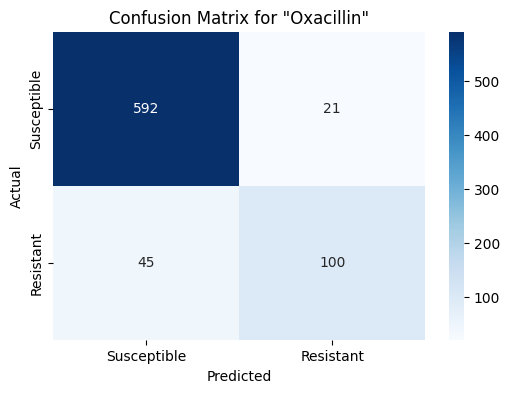

In [ ]:
y_pred_prob  = model.predict(X_test)
y_pred = (y_pred_prob>0.5)
cm = confusion_matrix(y_test, y_pred)

target_names = ['Susceptible', 'Resistant']
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f'Confusion Matrix for "{antibiotic}"')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred, target_names=target_names))

train_predictions_baseline = model.predict(X_train, batch_size=10)
test_predictions_baseline = model.predict(X_test, batch_size=10)

baseline_results = model.evaluate(X_test, y_test, return_dict=True, verbose=0)
for name, value in baseline_results.items():
  print(name, ': ', value)

auc = roc_auc_score(y_test, y_pred_prob)
aucpr = average_precision_score(y_test, y_pred_prob)
print(f"AUROC: {auc:0.4f},\nAUPRC: {aucpr:0.4f}")

print()

              precision    recall  f1-score   support

 Susceptible       0.93      0.97      0.95       613
   Resistant       0.83      0.69      0.75       145

    accuracy                           0.91       758
   macro avg       0.88      0.83      0.85       758
weighted avg       0.91      0.91      0.91       758

304/304 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
accuracy :  0.9129287600517273
auc :  0.8959048390388489
fn :  45.0
fp :  21.0
loss :  0.8030129075050354
prc :  0.7967042326927185
precision :  0.8264462947845459
recall :  0.6896551847457886
tn :  592.0
tp :  100.0
AUROC: 0.8998,
AUPRC: 0.8150



AUCROC and AUPRC Plots

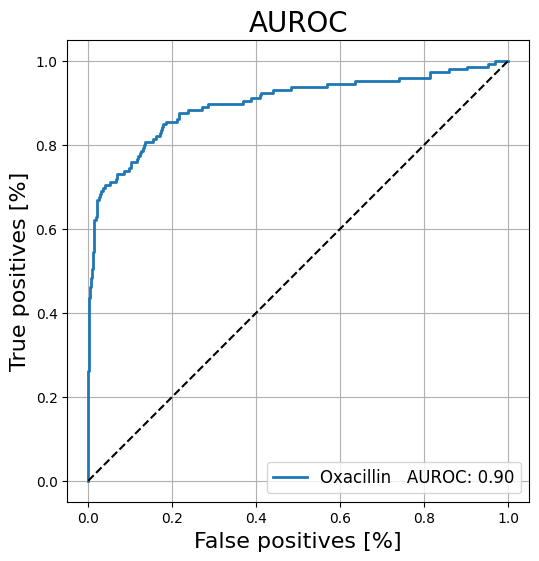

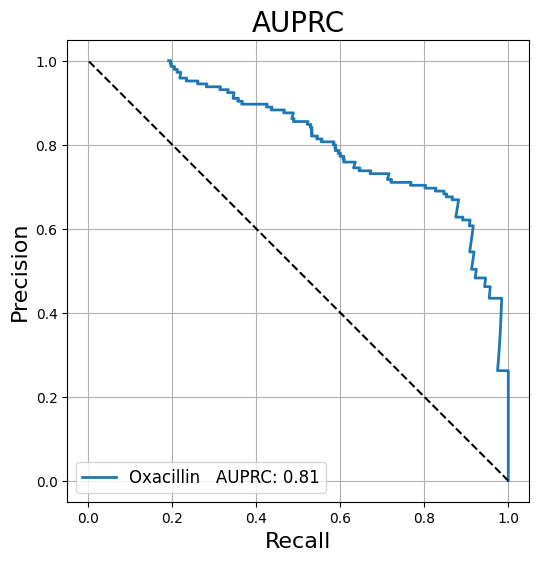

In [ ]:
plt.rcParams['figure.figsize'] = (8, 6)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlabel('False positives [%]', fontsize=16)
  plt.ylabel('True positives [%]', fontsize=16)
  plt.title('AUROC', fontsize=20)

  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

auroc = roc_auc_score(y_test, test_predictions_baseline)
plot_roc(f"{antibiotic}   AUROC: %0.2f" % auroc, y_test, test_predictions_baseline, color=colors[0])

plt.legend(loc='lower right', fontsize=12)
plt.show()

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.title('AUPRC', fontsize=20)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.plot([1, 0], [0, 1], 'k--')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

auprc = average_precision_score(y_test, test_predictions_baseline)
plot_prc(f"{antibiotic}   AUPRC: %0.2f" % auprc, y_test, test_predictions_baseline, color=colors[0])

plt.legend(loc='lower left', fontsize=12)
plt.show()

Multilabel Model

In [ ]:
X_train, X_test, y_train, y_test = create_dataset(df, antibiotics, 6000)

_, n_timesteps, n_features = X_train.shape

model = create_model(f's_aureus_{antibiotic}_multilabel_model', n_features, n_timesteps, n_targets=5)
model.summary()

Model: "s_aureus_Oxacillin_multilabel_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv_1 (Conv1D)                 │ (None, 5984, 64)       │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 5984, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 5984, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling1D_1 (MaxPooling1D)   │ (None, 2992, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_2 (Conv1D)                 │ (None, 2984, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 2984, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 2984, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling1D_2 (MaxPooling1D)   │ (None, 1492, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_3 (Conv1D)                 │ (None, 1488, 256)      │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1488, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 1488, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling1D_3 (MaxPooling1D)   │ (None, 744, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_4 (Conv1D)                 │ (None, 740, 256)       │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 740, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 740, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling1D_4 (MaxPooling1D)   │ (None, 370, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 94720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 94720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fully_connected_0 (Dense)       │ (None, 256)            │    24,248,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fully_connected_1 (Dense)       │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fully_connected_2 (Dense)       │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ OUT_Layer (Dense)               │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,839,365 (94.75 MB)

 Trainable params: 24,837,957 (94.75 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.000001)
early_st = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=1, validation_split=0.1, callbacks=[reduce_lr,early_st])

Epoch 1/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 28s 74ms/step - accuracy: 0.7893 - auc: 0.5698 - fn: 885.5569 - fp: 288.5490 - loss: 6.4902 - prc: 0.1849 - precision: 0.2021 - recall: 0.1244 - tn: 5151.4824 - tp: 74.1373 - val_accuracy: 0.8459 - val_auc: 0.5908 - val_fn: 218.0000 - val_fp: 0.0000e+00 - val_loss: 5.7103 - val_prc: 0.1948 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 1197.0000 - val_tp: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - accuracy: 0.8511 - auc: 0.6384 - fn: 920.7922 - fp: 49.1255 - loss: 5.4122 - prc: 0.2311 - precision: 0.3238 - recall: 0.0258 - tn: 5399.7568 - tp: 30.0510 - val_accuracy: 0.8459 - val_auc: 0.6490 - val_fn: 218.0000 - val_fp: 0.0000e+00 - val_loss: 4.8983 - val_prc: 0.2930 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 1197.0000 - val_tp: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8525 - auc: 0.6821 - fn: 

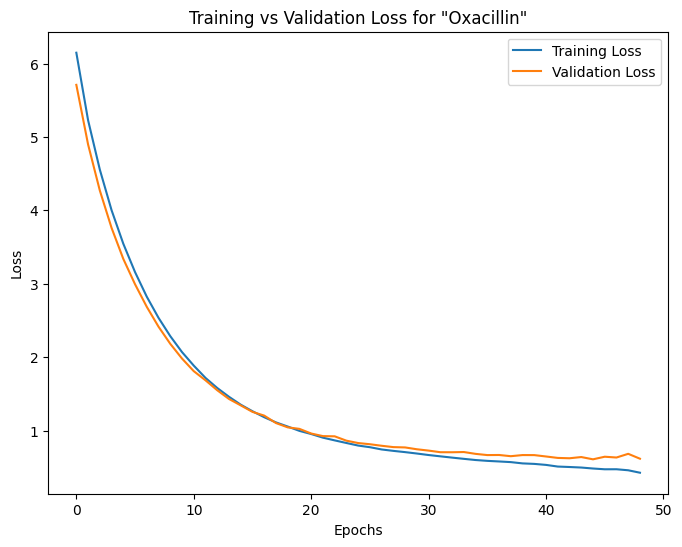

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training vs Validation Loss for "{antibiotic}"')
plt.legend()
plt.show()

In [ ]:
y_pred_prob  = model.predict(X_test)
y_pred = (y_pred_prob>0.5)
print(classification_report(y_test, y_pred, target_names=antibiotics))

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step
               precision    recall  f1-score   support

    Oxacillin       0.88      0.59      0.71       143
  Clindamycin       0.71      0.22      0.34       100
  Ceftriaxone       0.87      0.58      0.70       141
Ciprofloxacin       0.77      0.41      0.54       107
 Fusidic_acid       0.50      0.02      0.04        45

    micro avg       0.83      0.44      0.57       536
    macro avg       0.75      0.37      0.46       536
 weighted avg       0.79      0.44      0.55       536
  samples avg       0.13      0.12      0.12       536



In [ ]:
for i, _ in enumerate(antibiotics):
  auc = roc_auc_score(y_test[:, i], y_pred_prob[:, i])
  aucpr = average_precision_score(y_test[:, i], y_pred_prob[:, i])
  print(f"{antibiotics[i]}   AUROC: {auc:0.4f}, AUPRC: {aucpr:0.4f}")

Oxacillin   AUROC: 0.9292, AUPRC: 0.8455
Clindamycin   AUROC: 0.7288, AUPRC: 0.4479
Ceftriaxone   AUROC: 0.9266, AUPRC: 0.8434
Ciprofloxacin   AUROC: 0.8068, AUPRC: 0.6092
Fusidic_acid   AUROC: 0.7345, AUPRC: 0.2394
